In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from skimage.transform import resize
from project_scripts.widgets import dataset_movie_widget
from project_scripts.analyze import plot_training_curves, model_uncertainty
from project_scripts.data_loading import load_dataset, slices_to_textures, dataset_to_embeddings
from project_scripts.neural_networks import B_frame_CNN, texture_CNN

In [3]:
X_test, Y_test, _, _ = load_dataset('testing_data')
X_test_textures = slices_to_textures(X_test)
X_test_embeddings = dataset_to_embeddings(X_test, X_test_textures)

LOADING: directory=(testing_data) | label=([0, 1]) | total_bframes=(0)
LOADING: directory=(testing_data\cancer) | label=([0, 1]) | total_bframes=(0)
LOADING: directory=(testing_data\cancer\6-08-2017-s2) | label=([1, 0]) | total_bframes=(19)
LOADING: directory=(testing_data\cancer\6-24-2019-s2) | label=([1, 0]) | total_bframes=(68)
LOADING: directory=(testing_data\non_cancer) | label=([0, 1]) | total_bframes=(0)
LOADING: directory=(testing_data\non_cancer\8-24-2017-C1-s4) | label=([0, 1]) | total_bframes=(91)
LOADING: directory=(testing_data\non_cancer\8-24-2017-C2-s2) | label=([0, 1]) | total_bframes=(52)
51/51 [==============================] - 0s 2ms/step


In [4]:
print('TESTING DATA')
print(f'(num_slices, slice_height, slice_width, slice_channels): {X_test.shape}')
print(f'(num_textures, texture_height, texture_width, texture_channels): {X_test_textures.shape}')
print(f'(num_embeddings, len_embedding): {X_test_embeddings.shape}')
print(f'(num_labels, #_classes): {Y_test.shape} \n')

dataset_movie_widget(X_test_textures, Y_test)

TESTING DATA
(num_slices, slice_height, slice_width, slice_channels): (1610, 200, 100)
(num_textures, texture_height, texture_width, texture_channels): (1610, 100, 100, 1)
(num_embeddings, len_embedding): (1610, 128)
(num_labels, #_classes): (1610, 2) 



interactive(children=(Play(value=0, description='idx', interval=500, max=1609), IntSlider(value=0, description…

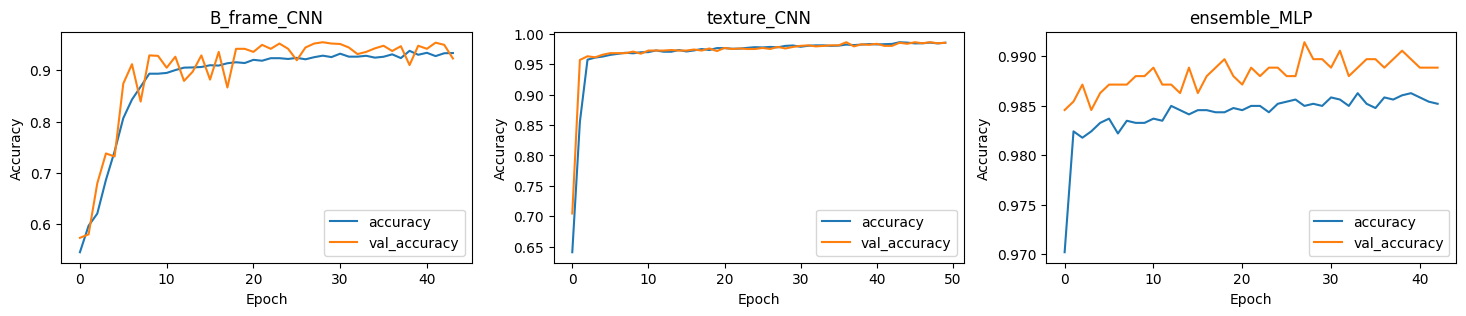

In [5]:
plt.subplots(1,3, figsize=(18,3))
plt.subplot(1,3,1)
plot_training_curves('saved_models\\final_models\\logs\\bframe_cnn_log.csv', 'B_frame_CNN')
plt.subplot(1,3,2)
plot_training_curves('saved_models\\final_models\\logs\\texture_cnn_log.csv', 'texture_CNN')
plt.subplot(1,3,3)
plot_training_curves('saved_models\\final_models\\logs\\ensemble_mlp_log.csv', 'ensemble_MLP')
plt.show()

In [6]:
model_uncertainty('saved_models\\final_models\\bframe_cnn', np.expand_dims(X_test, axis=3), Y_test)
model_uncertainty('saved_models\\final_models\\texture_cnn', X_test_textures, Y_test)
model_uncertainty('saved_models\\final_models\\ensemble_mlp', X_test_embeddings, Y_test)

B_frame_CNN -- 
mu: 85.05%, std: 0.44%

 texture_CNN -- 
mu: 94.28%, std: 0.16%

 ensemble_MLP -- 
mu: 94.06%, std: 0.11%


(0.9405590057373047, 0.0011300262024972587)

In [3]:
X_margin, _, _, _ = load_dataset('margin_data', step=1)
X_margin_textures = slices_to_textures(X_margin)
X_margin_embeddings = dataset_to_embeddings(X_margin, X_margin_textures)

LOADING: directory=(margin_data) | label=([0, 1]) | total_bframes=(0)
LOADING: directory=(margin_data\4-12-2021-WM3-1) | label=([0, 1]) | total_bframes=(256)
160/160 [==============================] - 0s 1ms/step


In [5]:
X_margin_textures.shape

(5120, 100, 100, 1)

160/160 [==============================] - 0s 2ms/step


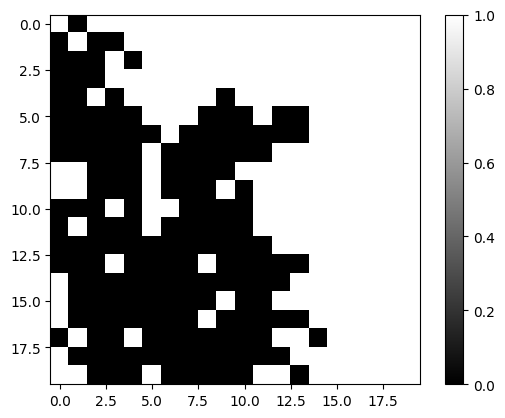

In [7]:
ensemble_model = tf.keras.models.load_model('saved_models\\final_models\\ensemble_mlp')
seg_map = ensemble_model.predict(X_margin_embeddings) > 0.5
seg_map = np.reshape(seg_map[:,0], (256,20))
plt.imshow(resize(seg_map, (20,20)), cmap='gray')
plt.colorbar()
plt.show()

In [ ]:
model3 = B_frame_CNN(3, 'relu', 'same')
model3.load_weights('saved_models\\final_models\\bframe_cnn').expect_partial()
bframe_gradcam = model3.get_gradcam()

# model4 = texture_CNN(3, 'relu', 'same')
# model4.load_weights('saved_models\\final_models\\texture_cnn').expect_partial()
# texture_gradcam = model4.get_gradcam()

# adapted from: https://keras.io/examples/vision/grad_cam/
def make_heatmap(input, model, is_texture=False):

    with tf.GradientTape() as tape:
        if(is_texture):
            last_conv_layer_output, preds = model(np.reshape(input, (1,100,100,1)))
        else: 
            last_conv_layer_output, preds = model(np.reshape(input, (1,200,100,1)))

        pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

    return heatmap.numpy()

bframe_heat_map = make_heatmap(B_frame_slice, bframe_gradcam)
texture_heat_map = make_heatmap(slice_texture, texture_gradcam, True)

print(model4.predict(np.reshape(slice_texture, (1,100,100,1))))
plt.imshow(slice_texture, cmap='gray')
plt.colorbar()
plt.imshow(resize(texture_heat_map, (100,100)), cmap='jet', alpha=0.2)
plt.colorbar()
plt.show()

In [9]:
import os
import numpy as np

def convert_csv_to_npy(directory):
    # List all files in the directory
    for filename in os.listdir(directory):
        # Check if the file is a CSV
        if filename.endswith('.csv'):
            # Construct full file path
            filepath = os.path.join(directory, filename)
            # Load the CSV file
            data = np.loadtxt(filepath, delimiter=',')
            # Save as .npy file
            np.save(filepath[:-4] + '.npy', data)
            # Remove the original CSV file
            os.remove(filepath)


convert_csv_to_npy('margin_data//4-12-2021-WM3-1')
print("Conversion completed!")


Conversion completed!
